In [1]:
# Libraries
from sklearn.metrics import mean_squared_error,mean_absolute_error
from keras.layers import Dense,Dropout,LSTM,Bidirectional,GRU
from keras.callbacks import EarlyStopping,Callback
from sklearn.preprocessing import MinMaxScaler
from pandas import DataFrame, read_csv,concat
from numpy import concatenate,reshape,array
from matplotlib import pyplot as plt
from keras.models import Sequential
from keras.optimizers import SGD
from statistics import mean
from keras import backend
from math import sqrt
from sys import argv
import datetime
import pickle
import talib
import docx
import time
import csv
import os

In [2]:
#Custom AutoStop
class EarlyStoppingByLossVal(Callback):
    def __init__(self, monitor='val_mape', value=1, verbose=0):
        super(Callback, self).__init__()
        self.monitor = monitor
        self.value = value
        self.verbose = verbose

    def on_epoch_end(self, epoch, logs={}):
        current = logs.get(self.monitor)
        if current is None:
            warnings.warn("Early stopping requires %s available!" % self.monitor, RuntimeWarning)        
            
        if epoch>10:
            if self.verbose > 0:
                print("Epoch %05d: early stopping THR" % epoch)
            if current < self.value:                
                self.model.stop_training = True

In [3]:
# Series to Supervised Learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):    
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
    # print("I: ",i)
        cols.append(df.shift(i))
        # print("Column: ",cols)
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
        # print("Names: ",names)
        
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        # print("COls: ",cols)
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
        # print("Names: ",names)

    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    
    return agg

In [4]:
#Set Feature Combinations
def get_CurrentCombo(dataframe, combo_number):
    combinations = [[4,5,6,7,8,9], [3,4,5,6,7,8], [3,4,5,6,7,9], [3,4,5,6,9,8], [4,5,6],[3,4,5,6], [3,4,5,7,9,8], [3,4,7,6,9,8],[3,4,7,9,8],[4,7,9,8]]
    newDataFrame = dataframe.drop(dataframe.columns[combinations[combo_number]], axis = 1)
    return newDataFrame

In [41]:
# Read Data and Extract Values
fileName = 'BTC'  #write crypto name
dataframe = read_csv('final_datasets/'+fileName+'.csv', parse_dates=['time']) 
startIndex = 3  #start from 3rd column
nrows = dataframe.shape[0]

# Add features
sma = talib.SMA(dataframe['open '+fileName], timeperiod = 10)
ema = talib.EMA(dataframe['open '+fileName], timeperiod = 10)
macd = talib.MACD(dataframe['open '+fileName])[0]
rsi = talib.RSI(dataframe['open '+fileName])
mom = talib.MOM(dataframe['open '+fileName], timeperiod=15)

dataframe.insert(5,'sma',sma)
dataframe.insert(6,'ema',ema)
dataframe.insert(7,'macd',macd)
dataframe.insert(8,'rsi',rsi)
dataframe.insert(9,'mom',mom)

passDataframe = dataframe

In [42]:
dataframe = get_CurrentCombo(passDataframe, 8) #Max 9

In [43]:
dataset=dataframe.iloc[33:,:]
values = dataset.iloc[:,startIndex:].values #Getting values - Total Sentiment and BTC Values
valuesCrypto = dataset.iloc[:,-1:].values #Getting values -  C Values



num =dataset.loc[dataset['time'] == '2020-12-01'].index[0] #Testing data starts from this date
num2= dataset.iloc[[-1]].index[0]
num2+=1
percent=num/num2
#percent=0.80 #Set a custom percentage of train data 

In [44]:
# Scaling
scaler = MinMaxScaler(feature_range = (0,1))
scaler = scaler.fit(values)
scaled = scaler.fit_transform(values)

In [45]:
# Input and Output Sequence Length
input_sequence = 1
output_sequence = 1


# Call Series to Supervised Function
reframed = series_to_supervised(scaled, input_sequence, output_sequence)

#Store Column Names for Documentation
Colname= dataframe.columns[3:-1]
Colname = '-'.join(Colname)

In [46]:
# Drop current sentiment/any other feature that might be added in the future(at time t)
dropColumns = []
for i in range(values.shape[1]-1):
    dropColumns.append('var{}(t)'.format(i+1))
reframed=reframed.drop(columns=dropColumns)

# Ignore the headers
reframedValues = reframed.values

In [47]:
#Splitting data into train and test sets

n_train_days = int(percent*nrows)
train = reframedValues[:n_train_days, :]
test = reframedValues[n_train_days:nrows, :]
# valuesCrypto = reframed.iloc[:,-1:].values #Getting values -  C Values

#Assigning inputs and output datasets
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

#Reshaping input to be 3 dimensions (samples, timesteps, features)
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))


In [48]:
##### Build LSTM Neural Network model
neurons = 40
dropout = 0.1
epochs = 100
batch_size = 64
backend.clear_session()
model = Sequential()
model.add(Bidirectional(GRU(neurons, activation='relu', return_sequences=True, input_shape=(train_X.shape[1], train_X.shape[2]))))
model.add(LSTM(neurons,activation ='tanh')) 
model.add(Dropout(dropout))
model.add(Dense(1))
backend.set_epsilon(1)
model.compile(optimizer='adam', loss='mse',metrics=['mape'])

# Uncomment below line to get summary of the model
# print(model.summary(line_length=None, positions=None, print_fn=None))

callbacks = [EarlyStoppingByLossVal(monitor='val_mape', value=2, verbose=2)]

#Fitting model
history = model.fit(train_X, train_y, epochs =epochs, batch_size=batch_size, validation_data=(test_X, test_y), verbose=2, shuffle=False,callbacks=callbacks) #Best so far: 100 neurons, epochs = 400, batch_size = 53
# print(history.history)

Epoch 1/100
88/88 - 1s - loss: 0.0011 - mape: 2.7088 - val_loss: 0.1444 - val_mape: 34.7866
Epoch 2/100
88/88 - 0s - loss: 0.0026 - mape: 3.5165 - val_loss: 0.0379 - val_mape: 17.7891
Epoch 3/100
88/88 - 0s - loss: 9.2285e-04 - mape: 1.9922 - val_loss: 6.5350e-04 - val_mape: 1.9768
Epoch 4/100
88/88 - 0s - loss: 9.7771e-05 - mape: 0.7240 - val_loss: 0.0056 - val_mape: 6.1701
Epoch 5/100
88/88 - 0s - loss: 4.8975e-05 - mape: 0.5236 - val_loss: 0.0037 - val_mape: 4.9605
Epoch 6/100
88/88 - 0s - loss: 4.7764e-05 - mape: 0.5166 - val_loss: 0.0030 - val_mape: 4.3823
Epoch 7/100
88/88 - 0s - loss: 4.4833e-05 - mape: 0.4862 - val_loss: 0.0025 - val_mape: 4.0365
Epoch 8/100
88/88 - 0s - loss: 4.1599e-05 - mape: 0.4681 - val_loss: 0.0014 - val_mape: 2.9177
Epoch 9/100
88/88 - 0s - loss: 4.3142e-05 - mape: 0.4925 - val_loss: 0.0020 - val_mape: 3.5072
Epoch 10/100
88/88 - 0s - loss: 4.0051e-05 - mape: 0.4499 - val_loss: 0.0019 - val_mape: 3.5049
Epoch 11/100
88/88 - 0s - loss: 4.0635e-05 - mape: 

In [49]:
# Predicition
model_prediction = model.predict(test_X)

# Inverse Scale
scalerCrypto = MinMaxScaler(feature_range = (0,1))
scalerCrypto = scaler.fit(valuesCrypto)
scaledCrypto = scaler.fit_transform(valuesCrypto)


model_prediction_unscale = scalerCrypto.inverse_transform(model_prediction)
predictedValues = reshape(model_prediction_unscale, model_prediction_unscale.shape[0])

actualValues = valuesCrypto[n_train_days+input_sequence:] #test_y+input_sequence:


actualValues = reshape(actualValues, actualValues.shape[0])


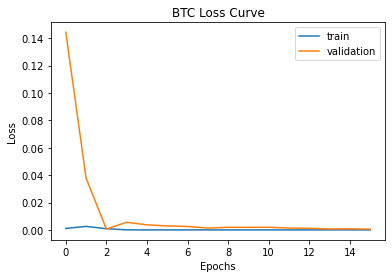

In [50]:
#Plotting training loss vs validation loss
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.title(fileName+' Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('LossCurves/'+fileName+'/'+fileName+"-"+Colname+'.png', dpi=700)
plt.show()

In [51]:
#Uncomment to make directories

# assets_filename = os.listdir('./final_datasets')
# assets_filename
# assets = [x.split('.')[0] for x in assets_filename]
# for asset in assets:    
#     os.mkdir('Trend_Graphs/'+asset)

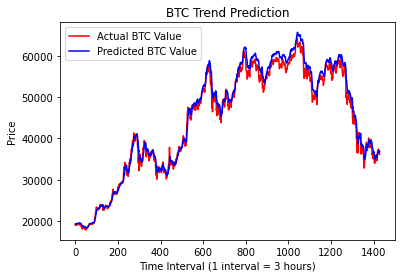

In [52]:
#Visualising Results (Actual vs Predicted)
plt.plot(actualValues, color = 'red', label = 'Actual '+ fileName + ' Value')
plt.plot(predictedValues, color = 'blue', label = 'Predicted '+ fileName + ' Value') #[1:38]
plt.title(fileName+' Trend Prediction')
plt.xlabel('Time Interval (1 interval = 3 hours)')
plt.ylabel('Price')
plt.legend()

# Uncomment below line to save the figure
plt.savefig('Trend_Graphs/'+fileName+'/'+fileName+"-"+Colname+'.png', dpi=700)

plt.show()

In [53]:
actual= DataFrame(actualValues, columns= ['Actual Value'])
predicted=DataFrame(predictedValues, columns= ['Predicted Value'])

#Calculating RMSE and MAE
errorDF=concat([actual,predicted], axis=1)
errorDF.dropna(inplace=True)
rmse = sqrt(mean_squared_error(errorDF.iloc[:,0], errorDF.iloc[:,1]))
mae = mean_absolute_error(errorDF.iloc[:,0], errorDF.iloc[:,1])
print('Test MAE: %.3f' % mae)
print('Test RMSE: %.3f' % rmse)

Test MAE: 1119.615
Test RMSE: 1473.489


In [54]:
# Write to csv
writeFileName = "-"+Colname+"-Results.csv"
timestamp = DataFrame(dataset['time'][n_train_days:], columns= ['time'])
timestamp.reset_index(drop=True, inplace=True)
results=concat([timestamp,actual,predicted], axis=1)
print("Head: ",results.head())
print("Tail: ",results.tail())
results.dropna(inplace=True)
results.to_csv('Results-5 features/'+fileName+'/'+fileName+writeFileName, index= False)

Head:                   time  Actual Value  Predicted Value
0 2020-12-05 03:00:00  18962.690000     19224.525391
1 2020-12-05 06:00:00  19143.063333     19251.757812
2 2020-12-05 09:00:00  19034.043333     19321.839844
3 2020-12-05 12:00:00  19108.886667     19277.511719
4 2020-12-05 15:00:00  19135.250000     19305.167969
Tail:                      time  Actual Value  Predicted Value
1425 2021-06-01 06:00:00  36304.003333     37031.382812
1426 2021-06-01 09:00:00  36592.830000     36789.175781
1427 2021-06-01 12:00:00  36265.610000     36945.484375
1428 2021-06-01 15:00:00  36158.190000     36798.722656
1429 2021-06-01 18:00:00           NaN              NaN


In [55]:
# Analyzer 2
result_value=[]

for n_percent in range(3):
    #n_percent = iteration/10.0
    with open('Results-5 features/'+fileName+'/'+fileName+writeFileName, newline='') as read_file:

        results = csv.reader(read_file, delimiter=',', quotechar='|')
        next(results)

        time = []
        actual = []
        predicted = []

        # Pull data from CSV and store in arrays.
        for row in results:
            # print(row)
            time.append(row[0])
            actual.append(float(row[1]))
            predicted.append(float(row[2]))

        actual_delta = []
        predicted_delta = []
        correct_long = 0
        incorrect_long = 0
        correct_short = 0
        incorrect_short = 0

        profit = []
        profit_agg = 0
        
        # Process predictions, print analytics.
        for i in range(2, len(actual) - 2):
            a_delta = (actual[i + 1] - actual[i]) / actual[i + 1]
            p_delta = (predicted[i + 1] - predicted[i]) / predicted[i + 1]
            #Uncomment below and comment above to see shifted values
            #p_delta = (predicted[i + 2] - predicted[i+1]) / predicted[i + 2]
    #         print("time_start", time[i])
    #         print("time_ended", time[i+1])
    #         print("actual_price", actual[i], "->", actual[i+1])
    #         print("actual_delta", a_delta * 100)
    #         print("predicted_price", predicted[i], "->", predicted[i + 1])
    #         print("predicted_delta", p_delta * 100)
    #         print("difference", abs(a_delta - p_delta) * 100)

            if p_delta > 0 and a_delta > 0 and abs(p_delta)*100>n_percent:
                correct_long += 1
                profits = 10000 * abs(a_delta)
                profit.append(profits)
                profit_agg += profits
                #print('gain/loss', profits)

            if p_delta > 0 > a_delta and abs(p_delta)*100>n_percent:
                incorrect_long += 1
                profits = -10000 * abs(a_delta)
                profit.append(profits)
                profit_agg += profits
                #print('gain/loss', profits)

            # To ignore the "short" predictions, comment out the following 2 if-blocks.

            if p_delta < 0 and a_delta < 0 and abs(p_delta)*100>n_percent:
                correct_short += 1
                profits = 10000 * abs(a_delta)
                profit.append(profits)
                profit_agg += profits
                #print('gain/loss', profits)

            if p_delta < 0 < a_delta and abs(p_delta)*100>n_percent:
                incorrect_short += 1
                profits = -10000 * abs(a_delta)
                profit.append(profits)
                profit_agg += profits
                #print('gain/loss', profits)
            

    #         print()
        long_p=correct_long/(correct_long+incorrect_short)*100
        short_p=correct_short/(correct_short+incorrect_long)*100
        total_correct= (correct_long+correct_short)/(correct_long+incorrect_long+correct_short+incorrect_short)*100
#         print('Analyzer 2 - Percent: ',n_percent)
#         print("------------")
#         print('LONG VALUES')
#         print('')
#         print('correct_long', correct_long)
#         print('incorrect_short', incorrect_short)
#         print('correct_long_percentage', long_p)
#         print('')
#         print('SHORT VALUES')
#         print('')
#         print('correct_short', correct_short)
#         print('incorrect_long', incorrect_long)
#         print('correct_short_percentage', short_p)
#         print('')
#         print('TOTAL')
#         print('')
#         print('total_correct',correct_short+correct_long)
#         print('total_incorrect',incorrect_long+incorrect_short )
#         print('correct_total_percentage', total_correct)
#         print('profit_tracker', profit_agg)
#         print()
#         print('########################################################')
#         print()
        
        st='LONG VALUES\n\ncorrect_long: {}\nincorrect_short: {}\ncorrect_long_percentage: {}\n\nSHORT VALUES\n\ncorrect_short: {}\nincorrect_long: {}\ncorrect_short_percentage: {}\n\nTOTAL\n\ntotal_correct: {}\ntotal_incorrect: {}\ncorrect_total_percentage: {}\nprofit_tracker: {}'.format(correct_long,incorrect_short,long_p,correct_short,incorrect_long,short_p,correct_short+correct_long,incorrect_long+incorrect_short,total_correct,profit_agg)
        result_value.append(st)

In [56]:
#Generate Document for Results
directory= "Result_Docs/"

try:
    os.mkdir(directory)
except: 
    pass
    
try:
    doc = docx.Document(directory+'Results-'+fileName+'.docx')
except:
    doc = docx.Document()
name=doc.add_paragraph()
bold= name.add_run(fileName+'-'+Colname)
bold.bold=True
image_path='Trend_Graphs/'+fileName+'/'+fileName+"-"+Colname+'.png'
doc.add_picture(image_path, width=None, height=None)

menuTable = doc.add_table(rows=1,cols=3)
menuTable.style= 'Table Grid'
hdr_Cells = menuTable.rows[0].cells
hdr_Cells[0].text = 'Results'
hdr_Cells[1].text = 'Results 1% Change'
hdr_Cells[2].text = 'Results 2% Change'
row_Cells = menuTable.add_row().cells

for i, results in enumerate(result_value):
    row_Cells[i].text= results
doc.add_page_break()
doc.save(directory+'Results-'+fileName+'.docx')
#os.system("start Results_for_all_Assets.docx")

In [57]:
#Generate Document for Hyperparameters
try:
    doc = docx.Document('CONFIG.docx')
except:
    doc = docx.Document()
    
name=doc.add_paragraph()
bold= name.add_run('\n\n'+fileName+'-'+Colname)
bold.bold=True

records = [epochs, batch_size, neurons, dropout]

menuTable = doc.add_table(rows=1,cols=4)
menuTable.style= 'Table Grid'
hdr_Cells = menuTable.rows[0].cells
hdr_Cells[0].text = 'Epoch'
hdr_Cells[1].text = 'Batch Size'
hdr_Cells[2].text = 'Neurons'
hdr_Cells[3].text = 'Dropout'

row_Cells = menuTable.add_row().cells
# row_Cells[0].text = str(epochs)
# row_Cells[1].text =
# row_Cells[2].text=
# row_Cells[3].text = str(dropout)

for i, item in enumerate(records):
    row_Cells[i].text = str(item)

# doc.add_page_break()
doc.save('CONFIG.docx')
#os.system("CONFIG.docx")